# Quantumquipu Challenge 
### Integrantes : 
                - Ivan Miranda. 
                            
                - Javier Feijóo.
## Reto: Decodificar y Clasificar

Reto para el Qiskit Fall Fest Latino, Escuela en Español de Computación Cuántica

Este proyecto se enfoca en codificar los archivos en al menos dos formas diferentes en un circuito cuántico variacional.

Diseña un circuito cuántico variacional para cada una de las codificaciones.

**El ganador será el que llegue a obtener el mejor accuracy con su modelo propuesto.**

In [1]:
import numpy as np
from numpy import linalg 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from sklearn.svm import SVC
from qiskit.algorithms.optimizers import SPSA
from qiskit import Aer, execute
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, PauliFeatureMap, StatePreparation, RYGate, EfficientSU2, PauliTwoDesign
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA
from qiskit import QuantumCircuit 
from qiskit.circuit import  Parameter, ParameterVector
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import QuantumKernel
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.random import random_circuit
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.decomposition import PCA
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC


# Dataset

In [2]:
train = pd.read_csv("challenge_train.csv")
test = pd.read_csv("challenge_test.csv")
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
train.head()

F1        F2        F3        F4  Target
0 -0.291592  1.854606 -0.226004  1.694754       1
1  0.327501  1.584748 -1.300541  0.471729       1
2  0.227985  1.512023 -0.646984 -0.743707       1
3 -0.453525  1.819041 -0.870957 -1.452390       1
4 -1.480420  1.278968 -1.193171 -0.000952       1

### Dimensiones de datasets 
**Train :** 
- Features = 4 
- Entries = 800



**Test :**  
* Featues = 4
* Entries 200

In [4]:
# separamos los conjuntos train y test
target_name = 'Target'
y_train = train[target_name]
X_train = train.drop(target_name, axis=1)
y_test = test[target_name]
X_test = test.drop(target_name, axis=1) 

#Escalado de datos
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

#Renombravamos el conjunto de datos
train_features, test_features, train_labels, test_labels = X_train,X_test,y_train, y_test

# 1. Métodos de Encoding

Matemáticamente podemos describir $\phi(x)$ como una relacion clásica entre los conjuntos $\chi $  y $T$  (Target) . 
El primer paso para un algoritmo de clasificación es transformar la informacion clásica en estados cuánticos que contengan esa información. Este proceso llamado encoding transforma el conjunto $\chi \rightarrow \left|\left.\chi(\vec{x})\right\rangle \right. $

Vamos a explorar varios métodos de encoding.
Tanto como en el Angular Encoding como en Encoding arbitrarios cada feature $N=4$ del dataset se parametriza en N gates sobre n qubits donde $n<=N$.  Inicialmente usamos los feature maps de Qiskit para hacer el encoding de los datos 

## 1.1 PauliFeatureMap


The [`PauliFeatureMap`](https://learn.qiskit.org/summer-school/2021/lab3-introduction-quantum-kernels-support-vector-machines) is defined as:

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

and describes the unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.


Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & if\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & if\ S=\{i,j\}
    \end{array}$$

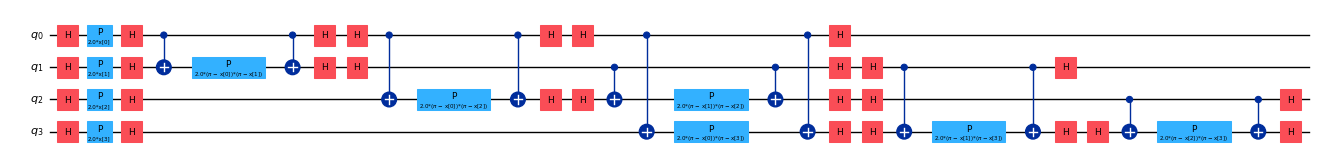

In [5]:
# Ejemplo de PauliFeatureMap: 4 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=4,alpha=2.0, reps=1
                  ,entanglement='full',paulis=['Z', 'XX'])
map_pauli.decompose().draw(output="mpl",fold=-1, scale=0.5,style='iqx')

## 1.2 ZFeatureMap

when $k = 1, P_0 = Z$, this is the [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html): 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

which is defined as:
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

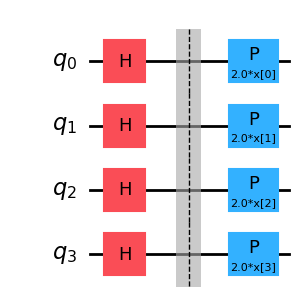

In [6]:
# Ejemplo de ZFeatureMap: 4 features, depth 1
map_z = ZFeatureMap(feature_dimension=4, reps=1,insert_barriers=True)
map_z.decompose().draw('mpl',style='iqx')

tenga en cuenta la falta de entrelazamiento en este mapa de características, esto significa que este mapa de características es simple de simular de manera clásica y no proporcionará una ventaja cuántica.


## 1.3 ZZFeatureMap 

and when $k = 2, P_0 = Z, P_1 = ZZ$, this is the  [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html):  
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

which is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

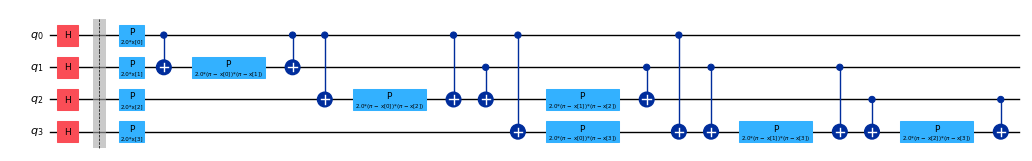

In [7]:
# Ejemplo de ZZFeatureMap: X_train.shape[1] features, depth 1
num_features = X_train.shape[1]
ZZfeature_map = ZZFeatureMap(feature_dimension=num_features, reps=1,insert_barriers=True)
ZZfeature_map.decompose().draw(output="mpl",fold=-1, scale=0.5,style='iqx')

Ahora que hay entrelazamiento en el mapa de características, podemos definir el mapa de entrelazamiento:


Se puede modificar el número de repeticiones del mapa de características ZZfeature_map

In [8]:
ZZfeature_map_reps2 = ZZFeatureMap(feature_dimension=num_features, reps=2)
ZZfeature_map_reps3 = ZZFeatureMap(feature_dimension=num_features, reps=3)
ZZfeature_map_reps4 = ZZFeatureMap(feature_dimension=num_features, reps=4)
ZZfeature_map_reps5 = ZZFeatureMap(feature_dimension=num_features, reps=5)

Esta variación de número de reps se podrá observar en el gráfico de kernesl, solo con fines didácticos.

## 1.4 Angle Encoding 

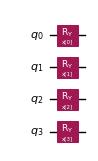

In [9]:
xparam = ParameterVector('x', length= 4)
AngleEncoding = QuantumCircuit(4)
AngleEncoding.ry(xparam[0], 0)
AngleEncoding.ry(xparam[1], 1)
AngleEncoding.ry(xparam[2], 2)
AngleEncoding.ry(xparam[3], 3)
AngleEncoding.draw(output="mpl",fold=-1, scale=0.5,style='iqx')

## 1.5 Encoding arbitrarios basados en el algoritmo de PauliTwoDesign


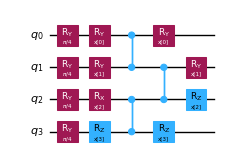

In [10]:
P2Design = PauliTwoDesign(num_qubits=4, reps=1)
P2param = [xparam[0],xparam[1],xparam[2],xparam[3],xparam[0],xparam[1],xparam[2],xparam[3]]
P2Design.ordered_parameters = P2param
P2Design.decompose().draw(output="mpl",fold=-1, scale=0.5,style='iqx')

Mediante la experimentación, llegamos a la conclusión que los enconding más óptimos para nuestro Dataset es el `ZZFeatureMap` y el `Angle Encoding` 

# 2. Gráfica de Kernels

Cada mapa de características define un kernel distinto sobre los datos de Train como de Test, La interpretacion del Kernel, y cada punto del gráfico de Kernel es la probabilidad de transición entre los estados que forman el espacio de Hilbert del sistema.

 $K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$ 
 
Se puede ver claramente que es simétrico con respecto a la diagonal. 
Las gráficas de kernels correspondiente a cada encoding nos da una idea a priori (forma visual) de que enconding es mejor para nuestro Dataset.

##### Gráfica de matrix de Kernel para train y test para cada enconding

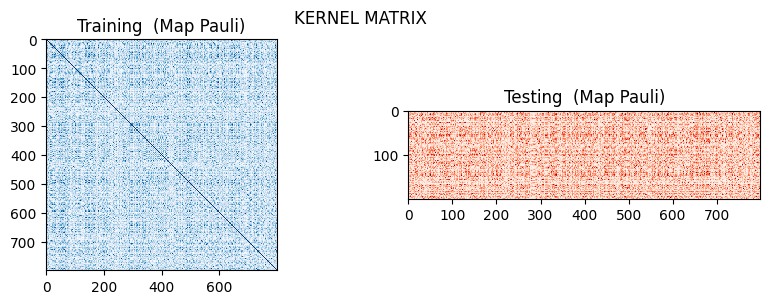

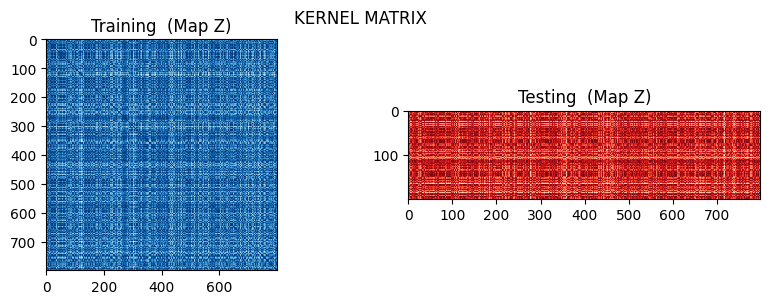

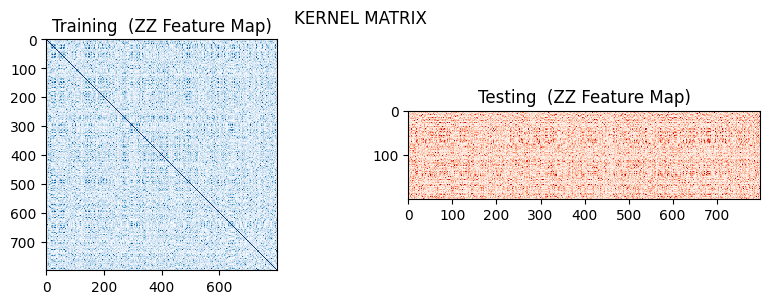

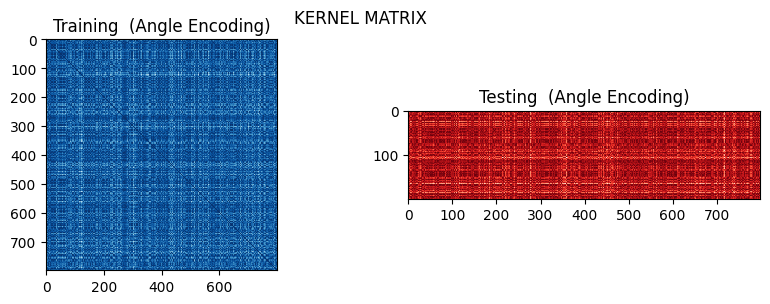

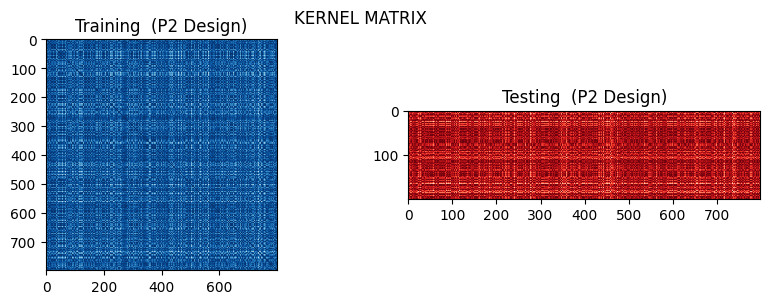

In [11]:
def Kernelplotter(x, title):
    xkernel = QuantumKernel(feature_map=x, quantum_instance=Aer.get_backend('statevector_simulator'))
    matrix_train = xkernel.evaluate(x_vec=train_features)
    matrix_test = xkernel.evaluate(x_vec=test_features, y_vec=train_features)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))  # Cambiando el tamaño de la figura
    
    axs[0].imshow(np.asmatrix(matrix_train), interpolation='nearest', origin='upper', cmap='Blues')
    axs[0].set_title(f"Training  ({title})")
    axs[1].imshow(np.asmatrix(matrix_test), interpolation='nearest', origin='upper', cmap='Reds')
    axs[1].set_title(f"Testing  ({title})")
    plt.suptitle("KERNEL MATRIX")  # Título de la figura
    plt.show()

# Lista de funciones de codificación
encoding_list = [map_pauli, map_z, ZZfeature_map, AngleEncoding, P2Design]
encoding_titles = ["Map Pauli", "Map Z", "ZZ Feature Map", "Angle Encoding", "P2 Design"]

# Iterar sobre las funciones de codificación y títulos correspondientes
for x, title in zip(encoding_list, encoding_titles):
    Kernelplotter(x, title)

Al observar las gráficas y sus densidades, los mejores encoding son `map_z`, `AngleEncoding` y `P2Design`.

##### Gráfica de matrix de Kernel (train y test) para ZZfeature_map con diferentes repeticiones

In [12]:
zzmaps = [ZZfeature_map,ZZfeature_map_reps2,ZZfeature_map_reps3,ZZfeature_map_reps4,ZZfeature_map_reps5]
zzmaps_titles = ["ZZfeature_map","ZZfeature_map_reps2","ZZfeature_map_reps3","ZZfeature_map_reps4","ZZfeature_map_reps5"]

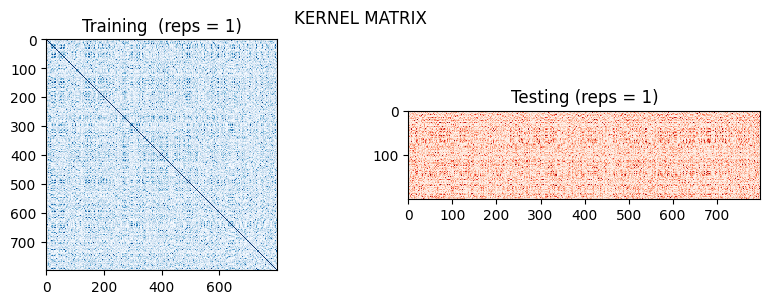

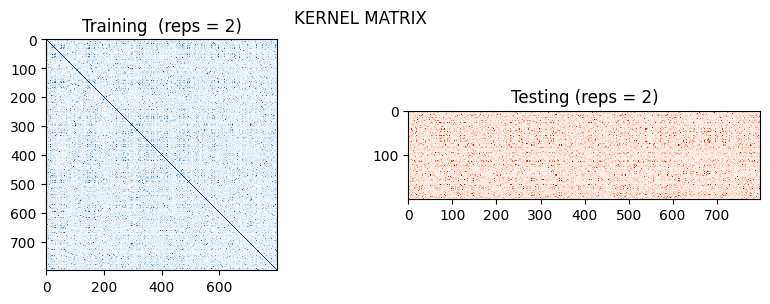

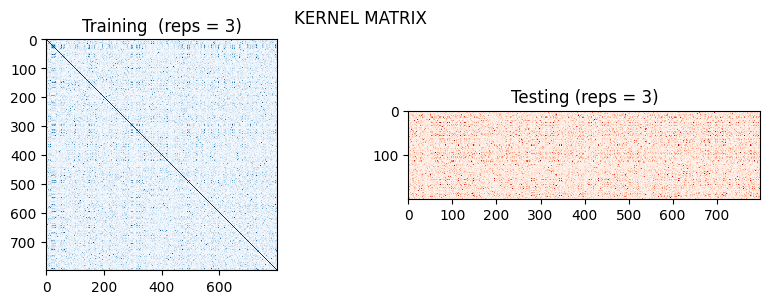

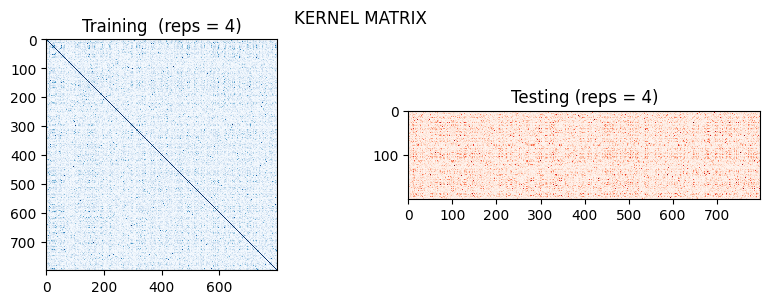

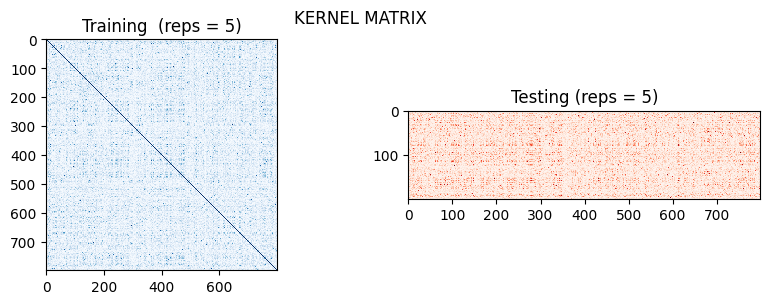

In [13]:
def Kernelplotter(x, title):
    xkernel = QuantumKernel(feature_map=x, quantum_instance=Aer.get_backend('statevector_simulator'))
    matrix_train = xkernel.evaluate(x_vec=train_features)
    matrix_test = xkernel.evaluate(x_vec=test_features, y_vec=train_features)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))  # Cambiando el tamaño de la figura

    axs[0].imshow(np.asmatrix(matrix_train), interpolation='nearest', origin='upper', cmap='Blues')
    axs[0].set_title(f"Training  ({title})")
    axs[1].imshow(np.asmatrix(matrix_test), interpolation='nearest', origin='upper', cmap='Reds')
    axs[1].set_title(f"Testing ({title})")

    plt.suptitle("KERNEL MATRIX")  # Título de la figura
    plt.show()

# Lista de funciones de codificación
zzmaps = [ZZfeature_map, ZZfeature_map_reps2, ZZfeature_map_reps3, ZZfeature_map_reps4, ZZfeature_map_reps5]
zzmaps_titles = ["reps = 1", "reps = 2", "reps = 3", "reps = 4", "reps = 5"]

# Iterar sobre las funciones de codificación y títulos correspondientes
for x, title in zip(zzmaps, zzmaps_titles):
    Kernelplotter(x, title)

Se puede observar que a medida que se aumenta el número de repeticiones, la densidad del mapa de caracterísicas disminuye. 

# 3. Parameters  Gate
El siguiente paso en el circuito de clasificación es el Gate de Ansatz donde va a estar el vector de parámetros $\vec{\theta }$, el cual sera luego optimizado para la clasificación. El Ansatz es un Gate Unitario el cual aplicado a un estado cuántico introduce la információn del vector de parámatros: 
$ \left|\left.\chi(\vec{x},\vec{\theta })\right\rangle \right.= U(\vec{\theta }) \left|\left.\chi(\vec{x})\right\rangle \right. $


## 3.1 RealAmplitude

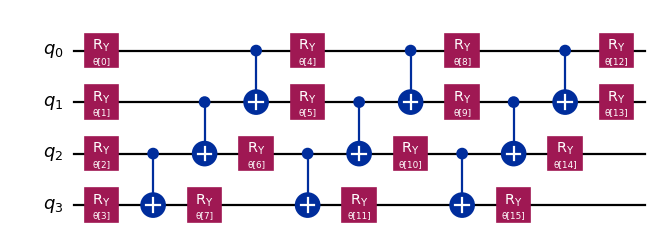

In [14]:
RAansatz = RealAmplitudes(num_qubits=num_features, reps=3)
RAansatz.decompose().draw(output="mpl", fold=20, scale=0.8,style='iqx')

## 3.2 EfficientSU2

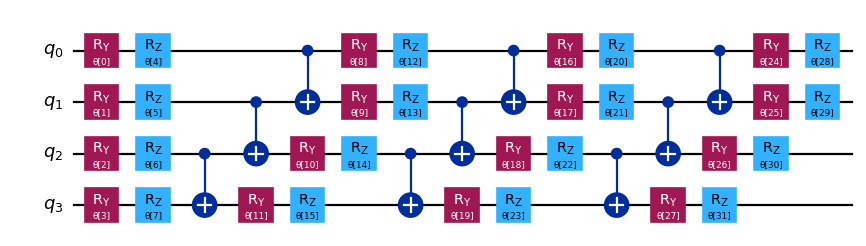

In [15]:
EFFSU2ansatz = EfficientSU2(num_qubits=num_features, reps=3,entanglement='reverse_linear' )
EFFSU2ansatz.decompose().draw(output="mpl", fold=20, scale=0.8,style='iqx')

De esta forma podemos ver que nuestro circuito tiene la siguiente forma 

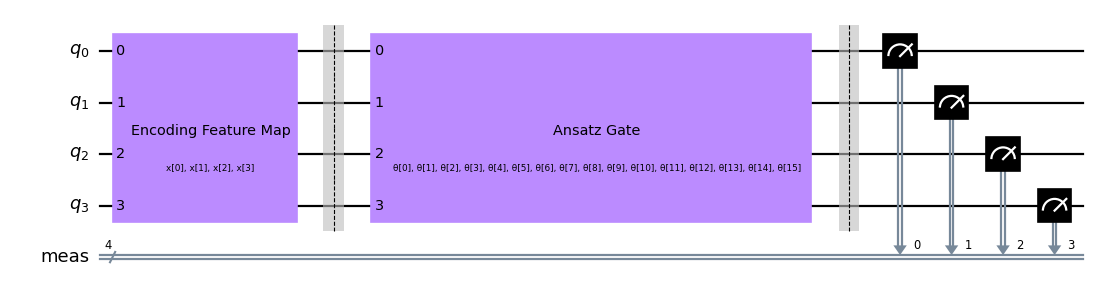

In [16]:
qc = QuantumCircuit(4)
EncodingGate = map_pauli.to_gate(label= "Encoding Feature Map" )
qc.append(EncodingGate,qc.qubits)
qc.barrier()
AnsatzGate = RAansatz.to_gate(label= "Ansatz Gate")
qc.append(AnsatzGate,qc.qubits)
qc.measure_all()
qc.draw(output="mpl",fold=-1, scale=0.8)

# 4. Optimizadores 

### 4.1 COBYLA

Descripción

In [17]:
optimizer = COBYLA(maxiter=80)
sampler = Sampler()

# 5. Entrenamiento

### Con 4 features

### ZZFeatureMap, RealAmplitudes y COBYLA (4 feactures)

In [19]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Loss vs Iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

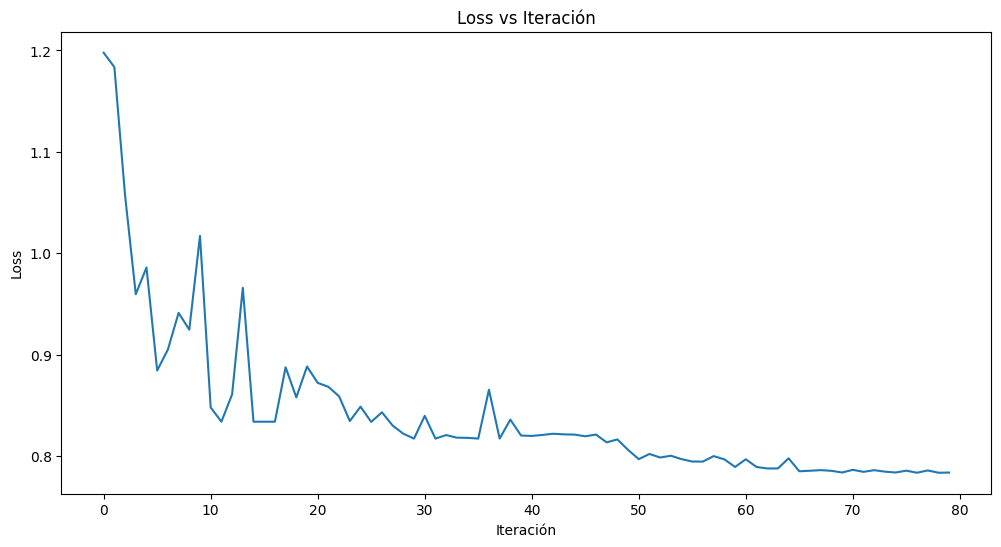

Training time: 1409 seconds


In [20]:
vqc = VQC(
    sampler=sampler,
    feature_map=ZZfeature_map,
    ansatz=RAansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# Convert pandas Series to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [21]:
train_score_q4_FM_RA_C = vqc.score(train_features, train_labels)
test_score_q4_FM_RA_C = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4_FM_RA_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_FM_RA_C:.4f}")

Quantum VQC on the training dataset: 0.7762
Quantum VQC on the test dataset:     0.7350


### ZZFeatureMap, EfficientSU2 y COBYLA (4 features)

In [22]:
objective_func_vals_2 = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph_2(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals_2.append(obj_func_eval)
    plt.title("Loss vs Iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals_2)), objective_func_vals_2)
    plt.show()

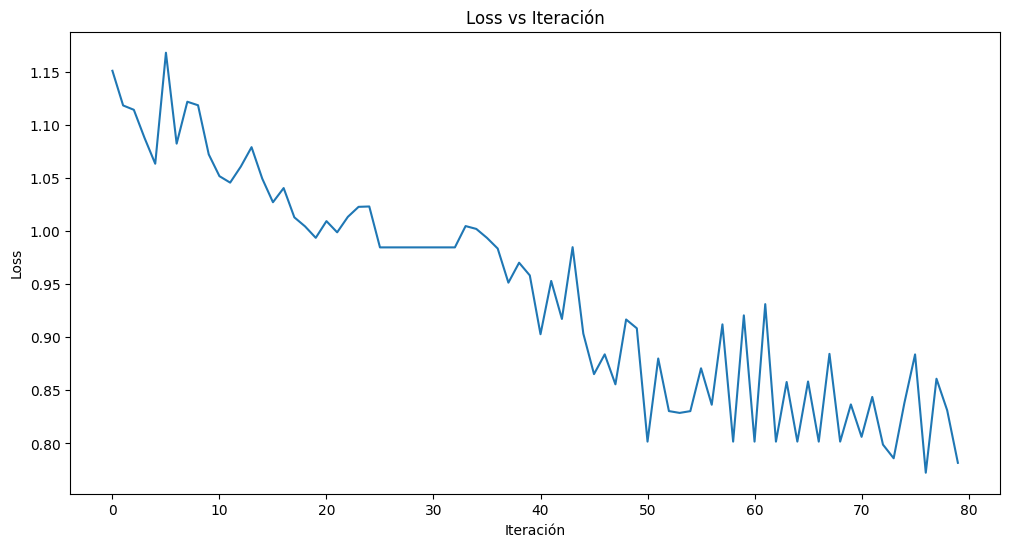

Training time: 1680 seconds


In [23]:
vqc = VQC(
    sampler=sampler,
    feature_map=ZZfeature_map,
    ansatz=EFFSU2ansatz,
    optimizer=optimizer,
    callback=callback_graph_2,
)

# clear objective value history
objective_func_vals_2 = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [24]:
train_score_q4_FM_Eff_C = vqc.score(train_features, train_labels)
test_score_q4_FM_Eff_C = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4_FM_Eff_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_FM_Eff_C:.4f}")

Quantum VQC on the training dataset: 0.7638
Quantum VQC on the test dataset:     0.8200


### AngleEncoding, RealAmplitudes y COBYLA (4 feactures)

In [25]:
optimizer = COBYLA(maxiter=80)
sampler = Sampler()

objective_func_vals_4 = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph_4(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals_4.append(obj_func_eval)
    plt.title("Loss vs Iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals_4)), objective_func_vals_4)
    plt.show()

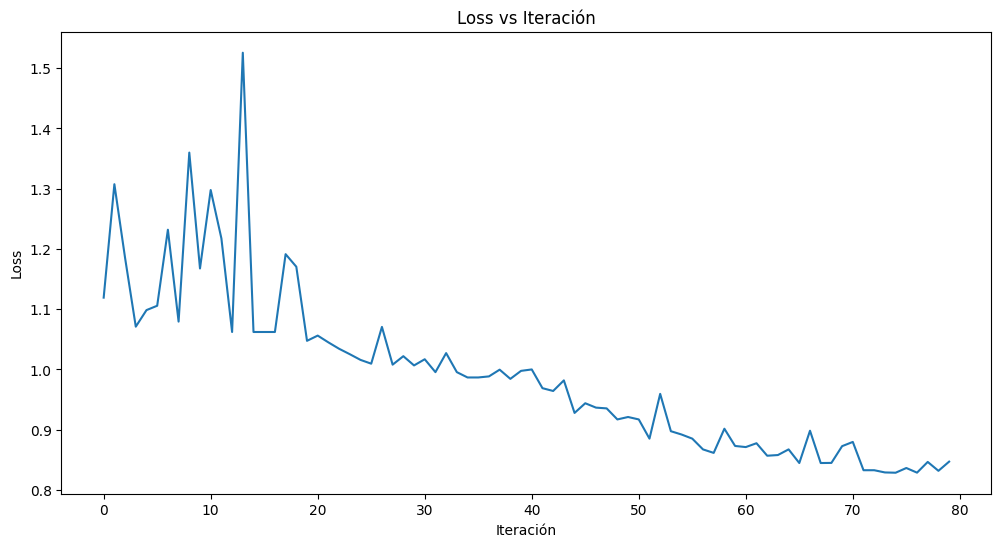

Training time: 354 seconds


In [26]:
vqc = VQC(
    sampler=sampler,
    feature_map=AngleEncoding,
    ansatz=RAansatz,
    optimizer=optimizer,
    callback=callback_graph_4,
)

# Convert pandas Series to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

objective_func_vals_4 = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [27]:
train_score_q4_AE_RA_C = vqc.score(train_features, train_labels)
test_score_q4_AE_RA_C = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4_AE_RA_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_AE_RA_C:.4f}")

Quantum VQC on the training dataset: 0.9775
Quantum VQC on the test dataset:     0.9750


### AngleEncoding, EfficientSU2 y COBYLA (4 feactures)

In [28]:
objective_func_vals_6 = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph_6(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals_6.append(obj_func_eval)
    plt.title("Loss vs Iteración")
    plt.xlabel("Iteración")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals_6)), objective_func_vals_6)
    plt.show()

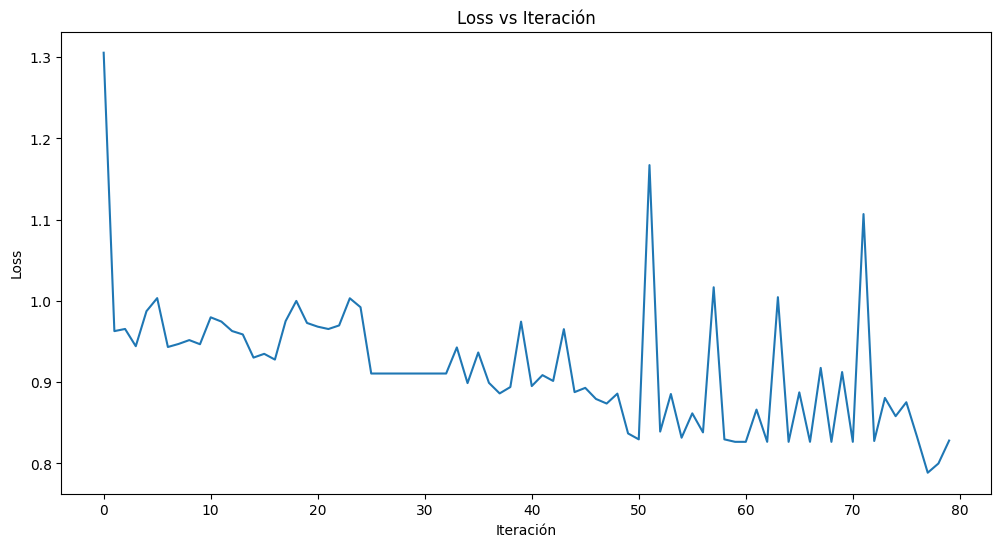

Training time: 620 seconds


In [29]:
vqc = VQC(
    sampler=sampler,
    feature_map=AngleEncoding,
    ansatz=EFFSU2ansatz,
    optimizer=optimizer,
    callback=callback_graph_6,
)
# clear objective value history
objective_func_vals_6 = []

# Convert pandas Series to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [30]:
train_score_q4_AE_Eff_C = vqc.score(train_features, train_labels)
test_score_q4_AE_Eff_C = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4_AE_Eff_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_AE_Eff_C:.4f}")

Quantum VQC on the training dataset: 0.8512
Quantum VQC on the test dataset:     0.9300


# Reducción de dimensioón (4-->2)

Features =
 [[0.47127616 0.63945035 0.44096594 0.75885855]
 [0.57449798 0.58410799 0.28236492 0.56915001]
 [0.55790566 0.56919371 0.37882966 0.38061865]
 ...
 [0.63294732 0.0476897  0.29581521 0.69291343]
 [0.34864536 0.36479758 0.64688142 0.25805025]
 [0.66273462 0.59978692 0.49345913 0.38540937]]
labels =
 0      1
1      1
2      1
3      1
4      1
      ..
795    0
796    1
797    0
798    1
799    1
Name: Target, Length: 800, dtype: int64
Features =
 [[ 0.36319697  0.09070316]
 [ 0.31365564  0.00921495]
 [ 0.30651862  0.0004568 ]
 ...
 [-0.21827251 -0.0929974 ]
 [ 0.10181504  0.13349153]
 [ 0.35024687 -0.12083687]]
labels =
 0      1
1      1
2      1
3      1
4      1
      ..
795    0
796    1
797    0
798    1
799    1
Name: Target, Length: 800, dtype: int64


<Axes: >

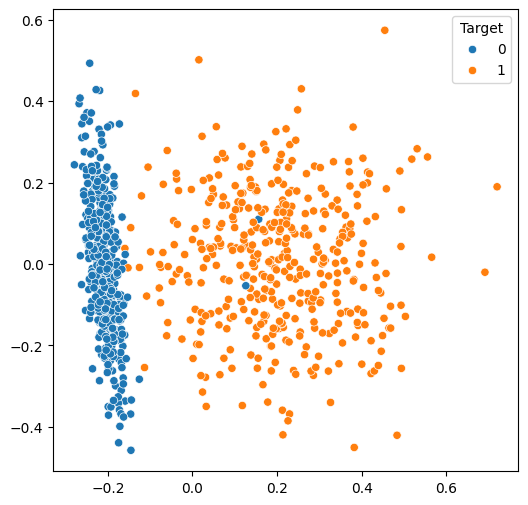

In [31]:
print("Features =\n", X_train)
print("labels =\n", y_train)
X_train = PCA(n_components=2).fit_transform(X_train)

print("Features =\n", X_train)
print("labels =\n", y_train)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="tab10")

Features =
 [[0.80301961 0.68591719 0.4136343  0.46613034]
 [0.61905527 0.04534474 0.3103077  0.35809433]
 [0.56848139 0.08126573 0.3199713  0.52752848]
 [0.34418224 0.75890637 0.48490919 0.64428436]
 [0.13815901 0.03405845 0.58276788 0.50057086]
 [0.90939317 0.06143022 0.56446854 0.47866017]
 [0.16449012 0.08999369 0.51791693 0.37624396]
 [0.14882658 0.07511866 0.40339287 0.43512872]
 [0.39049526 0.52718453 0.30452249 0.48983937]
 [0.25413692 0.3016067  0.38249335 0.57379801]
 [0.51761805 0.03783961 0.30914103 0.3786192 ]
 [0.08849315 0.08333998 0.22786156 0.28142128]
 [0.26883901 0.54248555 0.48383862 0.50630876]
 [0.65351651 0.83320198 0.19773587 0.36815206]
 [0.34765134 0.75947955 0.50603395 0.54494599]
 [0.54051568 0.05851269 0.20037552 0.27121536]
 [0.36346469 0.0566573  0.57133858 0.40897136]
 [0.53234985 0.38267008 0.41263835 0.23261497]
 [0.3452903  0.50256461 0.46345334 0.59747699]
 [0.18323397 0.03373899 0.40278558 0.55108331]
 [0.69481974 0.0640719  0.16122878 0.67848452]
 

<Axes: >

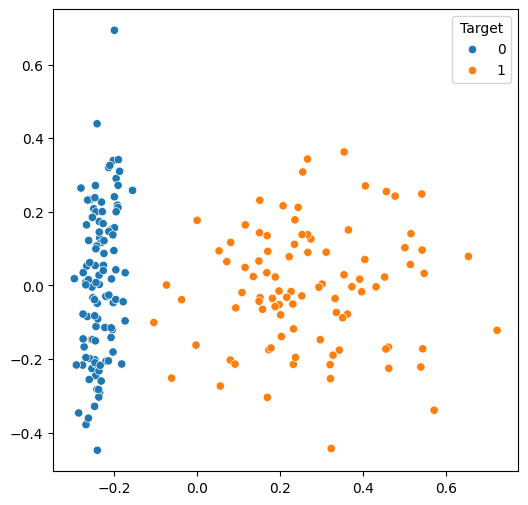

In [32]:
print("Features =\n", X_test)
print("labels =\n", y_test)
X_test = PCA(n_components=2).fit_transform(X_test)

print("Features =\n", X_test)
print("labels =\n", y_test)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette="tab10")

In [33]:
# Escalamiento
from sklearn.preprocessing import MinMaxScaler

X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

print("Features =\n", X_train)
print("labels =\n", y_train)
print("Features =\n", X_test)
print("labels =\n", y_test)

Features =
 [[0.64283478 0.53129571]
 [0.59325793 0.45233182]
 [0.58611579 0.44384497]
 ...
 [0.0609484  0.35328577]
 [0.38126544 0.5727586 ]
 [0.6298754  0.3263087 ]]
labels =
 0      1
1      1
2      1
3      1
4      1
      ..
795    0
796    1
797    0
798    1
799    1
Name: Target, Length: 800, dtype: int64
Features =
 [[0.68844371 0.62945344]
 [0.04575385 0.57500868]
 [0.08870393 0.5265956 ]
 [0.74309191 0.24558807]
 [0.01022281 0.08884108]
 [0.08111854 0.67312904]
 [0.05980475 0.13815093]
 [0.05045777 0.17758965]
 [0.51266458 0.37803532]
 [0.28770844 0.25041071]
 [0.03381895 0.49953312]
 [0.04861171 0.21546341]
 [0.51794124 0.20458839]
 [0.82192415 0.61019907]
 [0.73701004 0.24111826]
 [0.05066804 0.56758486]
 [0.03984837 0.26369644]
 [0.36069401 0.44930923]
 [0.48964198 0.27077508]
 [0.01946867 0.20281301]
 [0.09224532 0.69005289]
 [0.10169691 0.58356667]
 [0.40434833 0.53662263]
 [0.38173384 0.33903012]
 [0.50237959 0.36424747]
 [0.932157   0.4614925 ]
 [0.51836792 0.288963

In [34]:
train_features_1, test_features_1, train_labels_1, test_labels_1 = X_train,X_test,y_train, y_test

## Con 2 features

In [35]:
optimizer = COBYLA(maxiter=40)
sampler = Sampler()


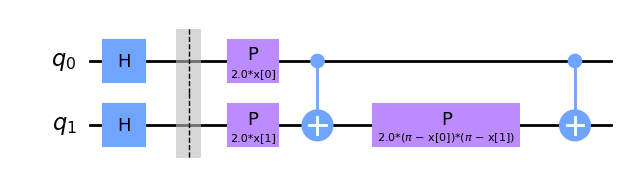

In [36]:
num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=2, reps=1
                          ,insert_barriers=True)
feature_map.decompose().draw(output="mpl", fold=20)

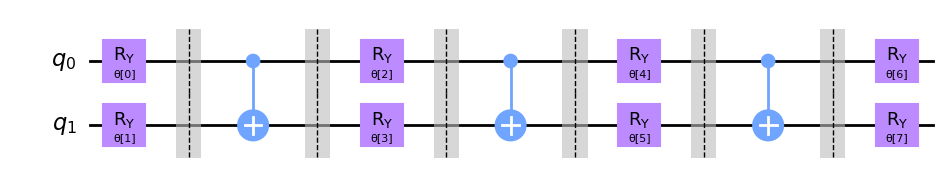

In [37]:
ansatz = RealAmplitudes(num_qubits=2, reps=3,
                        insert_barriers=True)
ansatz.decompose().draw(output="mpl", fold=20)

### ZZFeatureMap, RealAmplitudes y COBYLA (2 feactures)

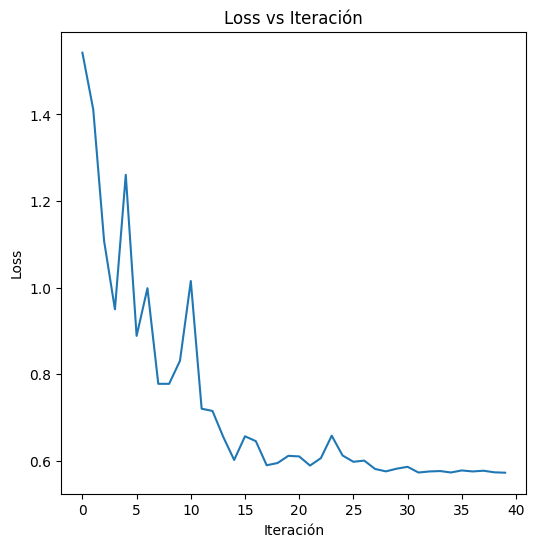

Training time: 220 seconds


In [38]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# Convert pandas Series to numpy arrays
train_features_1 = np.array(train_features_1)
train_labels_1 = np.array(train_labels_1)

start = time.time()
vqc.fit(train_features_1, train_labels_1)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [39]:
train_score_q2_FM_RA_C = vqc.score(train_features_1, train_labels_1)
test_score_q2_FM_RA_C = vqc.score(test_features_1, test_labels_1)

print(f"Quantum VQC on the training dataset: {train_score_q2_FM_RA_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2_FM_RA_C:.4f}")

Quantum VQC on the training dataset: 0.8900
Quantum VQC on the test dataset:     0.9000


### ZZFeatureMap, EfficientSU2 y COBYLA (2 feactures)

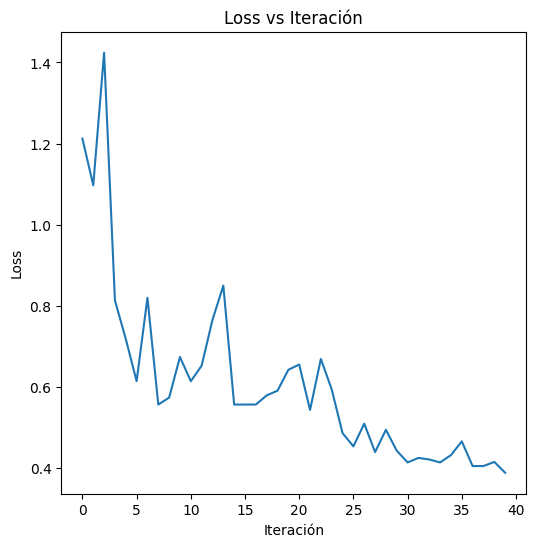

Training time: 277 seconds


In [40]:
ansatz_1 = EfficientSU2(num_qubits=2, reps=3)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz_1,
    optimizer=optimizer,
    callback=callback_graph_2,
)

# clear objective value history
objective_func_vals_2 = []

start = time.time()
vqc.fit(train_features_1, train_labels_1)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [41]:
train_score_q2_FM_Eff_C = vqc.score(train_features_1, train_labels_1)
test_score_q2_FM_Eff_C = vqc.score(test_features_1, test_labels_1)

print(f"Quantum VQC on the training dataset: {train_score_q2_FM_Eff_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2_FM_Eff_C:.4f}")

Quantum VQC on the training dataset: 0.9250
Quantum VQC on the test dataset:     0.9400


### AngleEncoding, RealAmplitudes y COBYLA (2 feactures)

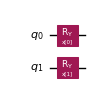

In [42]:
xparam_1 = ParameterVector('x', length=2)
AngleEncoding_1 = QuantumCircuit(2)
AngleEncoding_1.ry(xparam[0], 0)
AngleEncoding_1.ry(xparam[1], 1)

AngleEncoding_1.draw(output="mpl",fold=-1, scale=0.5,style='iqx')

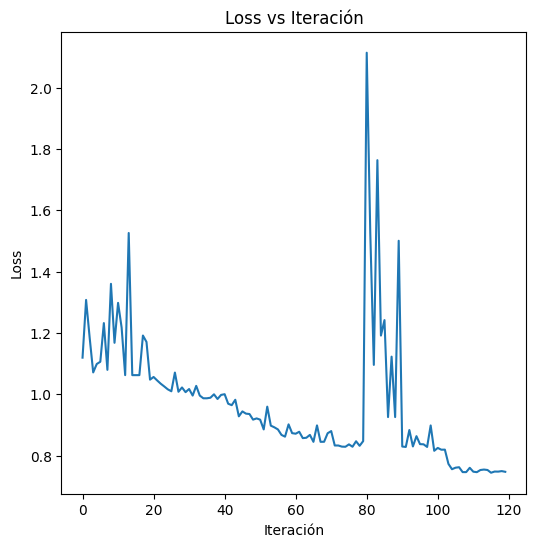

Training time: 103 seconds


In [43]:
vqc = VQC(
    sampler=sampler,
    feature_map=AngleEncoding_1,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph_4,
)
# clear objective value history
objective_func_vals = []

# Convert pandas Series to numpy arrays
train_features_1 = np.array(train_features_1)
train_labels_1 = np.array(train_labels_1)

start = time.time()
vqc.fit(train_features_1, train_labels_1)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [44]:
train_score_q2_AE_RA_C = vqc.score(train_features_1, train_labels_1)
test_score_q2_AE_RA_C = vqc.score(test_features_1, test_labels_1)

print(f"Quantum VQC on the training dataset: {train_score_q2_AE_RA_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2_AE_RA_C:.4f}")

Quantum VQC on the training dataset: 0.9725
Quantum VQC on the test dataset:     0.9850


### AngleEncoding, EfficientSU2 y COBYLA (2 feactures)

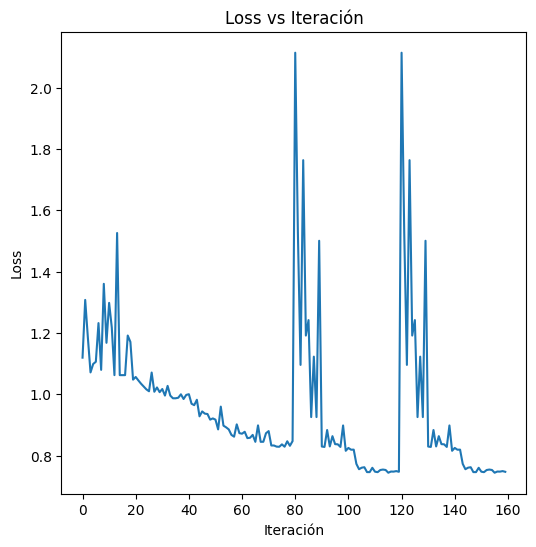

Training time: 101 seconds


In [45]:
ansatz_1 = EfficientSU2(num_qubits=2, reps=3)
qc = VQC(
    sampler=sampler,
    feature_map=AngleEncoding_1,
    ansatz=ansatz_1,
    optimizer=optimizer,
    callback=callback_graph_6,
)
# clear objective value history
objective_func_vals = []

# Convert pandas Series to numpy arrays
train_features_1 = np.array(train_features_1)
train_labels_1 = np.array(train_labels_1)

start = time.time()
vqc.fit(train_features_1, train_labels_1)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [46]:
train_score_q2_AE_Eff_C = vqc.score(train_features_1, train_labels)
test_score_q2_AE_Eff_C = vqc.score(test_features_1, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q2_AE_Eff_C:.4f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2_AE_Eff_C:.4f}")

Quantum VQC on the training dataset: 0.9725
Quantum VQC on the test dataset:     0.9850


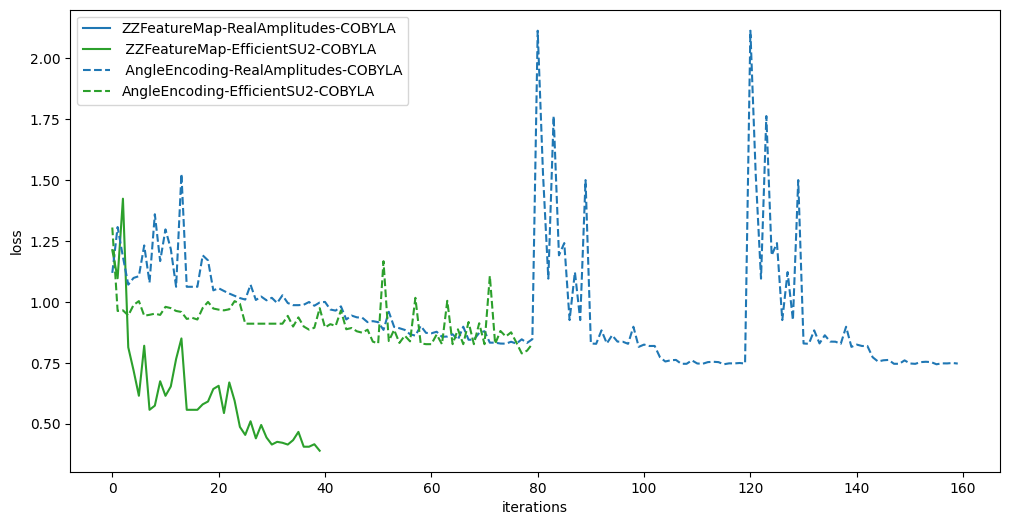

In [47]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(objective_func_vals, 'tab:blue', label='ZZFeatureMap-RealAmplitudes-COBYLA')
    plt.plot(objective_func_vals_2, 'tab:green', label=' ZZFeatureMap-EfficientSU2-COBYLA')
    plt.plot(objective_func_vals_4, 'tab:blue', ls='--', label=' AngleEncoding-RealAmplitudes-COBYLA')
    plt.plot(objective_func_vals_6, 'tab:green', ls='--', label='AngleEncoding-EfficientSU2-COBYLA')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
plot_loss() 

In [48]:
print(f"Model                                               | Test Score | Train Score")
print(f"VQC, 4 features, ZZFeatureMap-RealAmplitudes-COBYLA | {train_score_q4_FM_RA_C:10.4f} | {test_score_q4_FM_RA_C:10.4f}")
print(f"VQC, 4 features, ZZFeatureMap-EfficientSU2-COBYLA   | {train_score_q4_FM_Eff_C:10.4f} | {test_score_q4_FM_Eff_C:10.4f}")
print(f"VQC, 4 features, AngleEncoding-RealAmplitudes-COBYLA| {train_score_q4_AE_RA_C:10.4f} | {test_score_q4_AE_RA_C:10.4f}")
print(f"VQC, 4 features, AngleEncoding-EfficientSU2-COBYLA  | {train_score_q4_AE_Eff_C:10.4f} | {test_score_q4_AE_Eff_C:10.4f}")
print(f"-----------------------------------------------------------------------------")
print(f"VQC, 2 features, ZZFeatureMap-RealAmplitudes-COBYLA | {train_score_q2_FM_RA_C:10.4f} | {test_score_q2_FM_RA_C:10.4f}")
print(f"VQC, 2 features, ZZFeatureMap-EfficientSU2-COBYLA   | {train_score_q2_FM_Eff_C:10.4f} | {test_score_q2_FM_Eff_C:10.4f}")
print(f"VQC, 2 features, AngleEncoding-RealAmplitudes-COBYLA| {train_score_q2_AE_RA_C:10.4f} | {test_score_q2_AE_RA_C:10.4f}")
print(f"VQC, 2 features, AngleEncoding-EfficientSU2-COBYLA  | {train_score_q2_AE_Eff_C:10.4f} | {test_score_q2_AE_Eff_C:10.4f}")


Model                                               | Test Score | Train Score
VQC, 4 features, ZZFeatureMap-RealAmplitudes-COBYLA |     0.7762 |     0.7350
VQC, 4 features, ZZFeatureMap-EfficientSU2-COBYLA   |     0.7638 |     0.8200
VQC, 4 features, AngleEncoding-RealAmplitudes-COBYLA|     0.9775 |     0.9750
VQC, 4 features, AngleEncoding-EfficientSU2-COBYLA  |     0.8512 |     0.9300
-----------------------------------------------------------------------------
VQC, 2 features, ZZFeatureMap-RealAmplitudes-COBYLA |     0.8900 |     0.9000
VQC, 2 features, ZZFeatureMap-EfficientSU2-COBYLA   |     0.9250 |     0.9400
VQC, 2 features, AngleEncoding-RealAmplitudes-COBYLA|     0.9725 |     0.9850
VQC, 2 features, AngleEncoding-EfficientSU2-COBYLA  |     0.9725 |     0.9850


# 6. CONCLUSIÓN

Usar circuitos variacionales para clasificar un dataset es un método bastante amplio y la efectividad de clasificación es muy dependiente de los parámetros, Al no existir una "Receta" para armar el circuito , es importante tener algunas pistas por donde buscar. Nosotros encontramos una buena relacion entre el rendimiento de un circuito y dos caracteristicas. Una de ellas es el grafico del Kernel donde es evidente que cuando el Kernel muestra altas probabilidades de transición entre diferentes estados cuánticos es mejor el rendimiento del sistema, el otro punto es poder visualizar los datos, como el numero de caracteristicas del dataset era 4 necesitamos reducir las dimensiones. esto no solo permite visualizar las imagenes, si no que tambien mejora el rendimiento de su circuito equivalente en menor dimension. 
De esta forma hemos encontrado que el mejor encoding para el circuito de clasificación es el Angle encoding. y que el Gate variacional no tiene gran diferencia en este rendimiento. 